In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
    .config("spark.driver.memory", "8g")\
    .getOrCreate()

spark

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.sql.window import Window
from pyspark.sql.functions import col, lit

from common import *

pd.set_option('display.max_rows', 100)

In [3]:
PREFIX = "main/tpcc"

client_sdf = spark.read.csv(f"{PREFIX}/*/client/0/metadata.csv", header=True)\
    .withColumn(
        "prefix",
        ancestor_udf(F.input_file_name(), lit(3))
    )

server_sdf = spark.read.csv(f"{PREFIX}/*/server/0-0/metadata.csv", header=True)\
    .withColumn(
        "prefix",
        ancestor_udf(F.input_file_name(), lit(3))
    )

index_sdf = server_sdf.join(client_sdf, on='prefix')\
    .withColumn("duration", col("duration").cast(T.IntegerType()))\
    .withColumn("txns", col("txns").cast(T.IntegerType()))\
    .withColumn("clients", col("clients").cast(T.IntegerType()))\
    .withColumn("rate", col("rate").cast(T.IntegerType()))\
    .withColumn("sample", col("sample").cast(T.IntegerType()))

index_sdf.toPandas()

,prefix,version,config_name,duration,txns,clients,rate,sample,wl:name,wl:sh_only,wl:mix,wl:mh_zipf,wl:homes,wl:sp_partition
0,file:///home/ctring/data/slog/main/tpcc/baseli...,1.0.916,baseline.conf,30,0,100,0,10,tpcc,0,45:43:4:4:4,1,2,-1
1,file:///home/ctring/data/slog/main/tpcc/baseli...,1.0.916,baseline.conf,30,0,112,0,10,tpcc,0,45:43:4:4:4,1,2,-1
2,file:///home/ctring/data/slog/main/tpcc/ddr_ts...,1.0.916,ddr_ts.conf,30,0,100,0,10,tpcc,0,45:43:4:4:4,1,2,-1
3,file:///home/ctring/data/slog/main/tpcc/ddr_ts...,1.0.916,ddr_ts.conf,30,0,112,0,10,tpcc,0,45:43:4:4:4,1,2,-1
4,file:///home/ctring/data/slog/main/tpcc/baseli...,1.0.916,baseline.conf,30,0,12,0,10,tpcc,0,45:43:4:4:4,1,2,-1
5,file:///home/ctring/data/slog/main/tpcc/baseli...,1.0.916,baseline.conf,30,0,25,0,10,tpcc,0,45:43:4:4:4,1,2,-1
6,file:///home/ctring/data/slog/main/tpcc/baseli...,1.0.916,baseline.conf,30,0,37,0,10,tpcc,0,45:43:4:4:4,1,2,-1
7,file:///home/ctring/data/slog/main/tpcc/baseli...,1.0.916,baseline.conf,30,0,50,0,10,tpcc,0,45:43:4:4:4,1,2,-1
8,file:///home/ctring/data/slog/main/tpcc/baseli...,1.0.916,baseline.conf,30,0,62,0,10,tpcc,0,45:43:4:4:4,1,2,-1
9,file:///home/ctring/data/slog/main/tpcc/baseli...,1.0.916,baseline.conf,30,0,75,0,10,tpcc,0,45:43:4:4:4,1,2,-1


# Throughput

In [4]:
# Extract all prefixes in the index
throughput_df = index_sdf.select("prefix", "sample").toPandas()
# Compute the throughput of each prefix
throughput_df["throughput"] = throughput_df.apply(
    lambda row: throughput(
        spark,
        row["prefix"],
        row["sample"],
        trim_start_sec=0,
        trim_end_sec=0,
        new_version=True,
    ).first().throughput,
    axis=1
)
# Associate metadata from the index to the throughputs
throughput_df = throughput_df.merge(index_sdf.drop("sample").toPandas(), on="prefix")
# Try to cast columns to appropriate types 
throughput_df = throughput_df.convert_dtypes()

throughput_df.sort_values(by="config_name")

,prefix,sample,throughput,version,config_name,duration,txns,clients,rate,wl:name,wl:sh_only,wl:mix,wl:mh_zipf,wl:homes,wl:sp_partition
0,file:///home/ctring/data/slog/main/tpcc/baseli...,10,33040.874794,1.0.916,baseline.conf,30,0,100,0,tpcc,0,45:43:4:4:4,1,2,-1
10,file:///home/ctring/data/slog/main/tpcc/baseli...,10,32366.184161,1.0.916,baseline.conf,30,0,87,0,tpcc,0,45:43:4:4:4,1,2,-1
18,file:///home/ctring/data/slog/main/tpcc/baseli...,10,494.696929,1.0.916,baseline.conf,30,0,1,0,tpcc,0,45:43:4:4:4,1,2,-1
8,file:///home/ctring/data/slog/main/tpcc/baseli...,10,29187.334111,1.0.916,baseline.conf,30,0,62,0,tpcc,0,45:43:4:4:4,1,2,-1
7,file:///home/ctring/data/slog/main/tpcc/baseli...,10,24877.472267,1.0.916,baseline.conf,30,0,50,0,tpcc,0,45:43:4:4:4,1,2,-1
6,file:///home/ctring/data/slog/main/tpcc/baseli...,10,20841.429256,1.0.916,baseline.conf,30,0,37,0,tpcc,0,45:43:4:4:4,1,2,-1
9,file:///home/ctring/data/slog/main/tpcc/baseli...,10,32038.568659,1.0.916,baseline.conf,30,0,75,0,tpcc,0,45:43:4:4:4,1,2,-1
4,file:///home/ctring/data/slog/main/tpcc/baseli...,10,6763.850164,1.0.916,baseline.conf,30,0,12,0,tpcc,0,45:43:4:4:4,1,2,-1
1,file:///home/ctring/data/slog/main/tpcc/baseli...,10,33705.378065,1.0.916,baseline.conf,30,0,112,0,tpcc,0,45:43:4:4:4,1,2,-1
5,file:///home/ctring/data/slog/main/tpcc/baseli...,10,13704.258196,1.0.916,baseline.conf,30,0,25,0,tpcc,0,45:43:4:4:4,1,2,-1


<AxesSubplot:xlabel='Number of clients'>

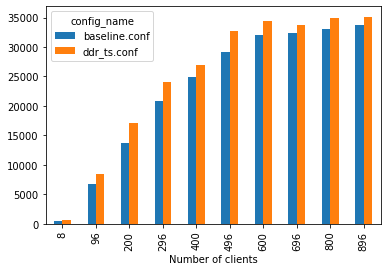

In [5]:
remove_constant_columns(throughput_df, ["config_name", "throughput"])
pivot_values = "throughput"
pivot_columns = "config_name"
pivot_index = throughput_df.columns.drop([pivot_values, pivot_columns, "prefix"])
pivoted = throughput_df.pivot(index=pivot_index, columns=pivot_columns, values=pivot_values)
pivoted["Number of clients"] = pivoted.index * 8
pivoted.sort_index().plot.bar(x="Number of clients")
# pivoted.sort_index().plot.bar()

## By Region

No handles with labels found to put in legend.


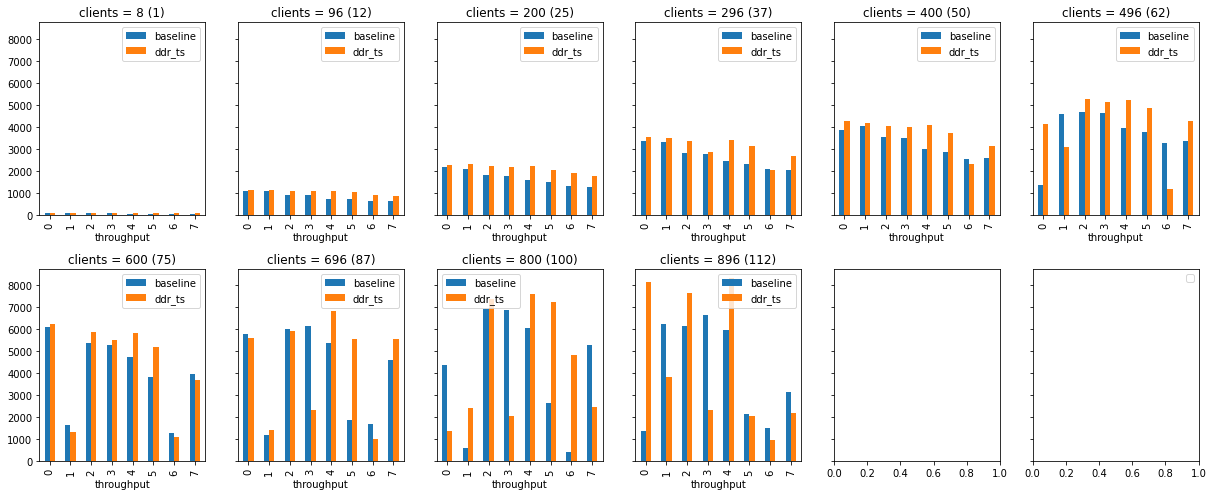

In [6]:
rows = 2
cols = 6
_, ax = plt.subplots(rows, cols, figsize=(17, 7), sharey=True)

index_df = index_sdf.toPandas()
clients_values = sorted(index_df["clients"].unique())
for i, clients in enumerate(clients_values):
    filtered = index_df.loc[index_df.clients == clients]

    baseline_prefix = filtered.loc[filtered.config_name == "baseline.conf", "prefix"].iat[0]
    baseline_sample = filtered.loc[filtered.config_name == "baseline.conf", "sample"].iat[0]
    baseline_throughput_per_region = throughput(
        spark,
        baseline_prefix,
        baseline_sample,
        per_region=True,
        trim_start_sec=5,
        trim_end_sec=5,
    )

    ddr_ts_prefix = filtered.loc[filtered.config_name == "ddr_ts.conf", "prefix"].iat[0]
    ddr_ts_sample = filtered.loc[filtered.config_name == "ddr_ts.conf", "sample"].iat[0]
    ddr_ts_throughput_per_region = throughput(
        spark,
        ddr_ts_prefix,
        ddr_ts_sample,
        per_region=True,
        trim_start_sec=5,
        trim_end_sec=5,
    )

    cmp = baseline_throughput_per_region.withColumnRenamed("throughput", "baseline")\
        .join(ddr_ts_throughput_per_region.withColumnRenamed("throughput", "ddr_ts"), "machine")\
        .toPandas()\
        .sort_values("machine")
 
    r, c = i // cols, i % cols
    cmp.plot.bar(ax=ax[r, c], x="machine")

    ax[r, c].set_title(f"clients = {clients * 8} ({clients})")
    ax[r, c].set_xlabel("throughput")

plt.legend()
plt.tight_layout()

# Latency

## By number of clients

file:///home/ctring/data/slog/main/tpcc/baseline-clients1
file:///home/ctring/data/slog/main/tpcc/ddr_ts-clients1
file:///home/ctring/data/slog/main/tpcc/baseline-clients12
file:///home/ctring/data/slog/main/tpcc/ddr_ts-clients12
file:///home/ctring/data/slog/main/tpcc/baseline-clients25
file:///home/ctring/data/slog/main/tpcc/ddr_ts-clients25
file:///home/ctring/data/slog/main/tpcc/baseline-clients37
file:///home/ctring/data/slog/main/tpcc/ddr_ts-clients37
file:///home/ctring/data/slog/main/tpcc/baseline-clients50
file:///home/ctring/data/slog/main/tpcc/ddr_ts-clients50
file:///home/ctring/data/slog/main/tpcc/baseline-clients62
file:///home/ctring/data/slog/main/tpcc/ddr_ts-clients62
file:///home/ctring/data/slog/main/tpcc/baseline-clients75
file:///home/ctring/data/slog/main/tpcc/ddr_ts-clients75
file:///home/ctring/data/slog/main/tpcc/baseline-clients87
file:///home/ctring/data/slog/main/tpcc/ddr_ts-clients87
file:///home/ctring/data/slog/main/tpcc/baseline-clients100
file:///home/c

No handles with labels found to put in legend.


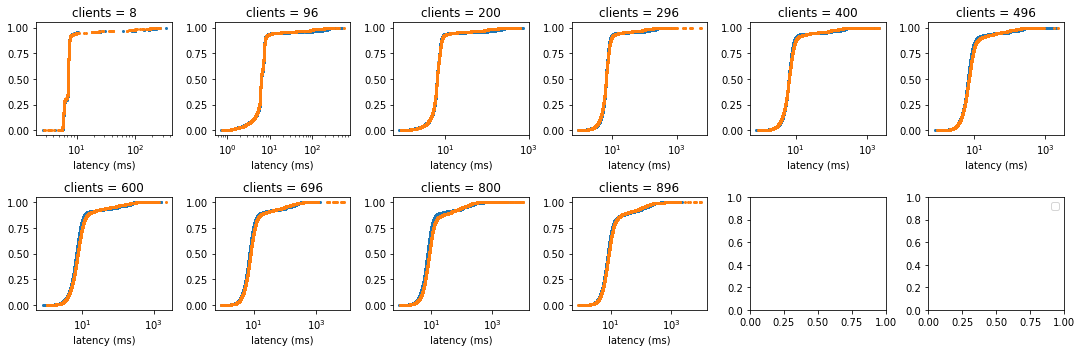

In [7]:
latency_tpcc = index_sdf.select("prefix", "config_name", "clients")\
    .orderBy("clients")\
    .toPandas()

rows = 2
cols = 6
_, ax = plt.subplots(rows, cols, figsize=(15, 5))

clients_values = latency_tpcc["clients"].unique()
for i, clients in enumerate(clients_values):
    filtered_clients = latency_tpcc.loc[latency_tpcc.clients == clients]

    filtered_baseline = filtered_clients.loc[filtered_clients.config_name == "baseline.conf"]
    print(filtered_baseline.prefix.iloc[0])
    baseline = latency(spark, filtered_baseline.prefix.iloc[0]).cache()
    
    filtered_ddr_ts = filtered_clients.loc[filtered_clients.config_name == "ddr_ts.conf"]
    print(filtered_ddr_ts.prefix.iloc[0])
    ddr_ts = latency(spark, filtered_ddr_ts.prefix.iloc[0]).cache()

    r, c = i // cols, i % cols
    
    plot_cdf(ax[r, c], baseline.toPandas()["latency"], label="baseline", linewidth=0, marker='o')
    plot_cdf(ax[r, c], ddr_ts.toPandas()["latency"], label="ddr", linewidth=0, marker='o')
    ax[r, c].set_title(f"clients = {clients * 8}")
    ax[r, c].set_xlabel("latency (ms)")

plt.legend()
plt.tight_layout()

# By regions

In [6]:
def extract_latency(index_sdf, clients, num_replicas):
    # Extract all prefixes in the index
    prefixes = index_sdf.select("prefix").where(col("clients") == clients).toPandas()["prefix"].to_list()

    latency_sdfs = []
    for p in prefixes:
        lat_sdf = latency(spark, p, where=(F.size("replicas") == num_replicas))\
            .withColumn("prefix", lit(p))\
            .join(index_sdf.where(col("prefix") == p), on="prefix")
        latency_sdfs.append(lat_sdf)

    latency_sdf = latency_sdfs[0]
    for l in latency_sdfs[1:]:
        latency_sdf = latency_sdf.union(l)

    return latency_sdf\
        .withColumn("coordinator_region", (col("coordinator") / 3).cast(T.IntegerType()))\
        .toPandas()


def latency_of_config(latency_df, config):
    return latency_df[latency_df.config_name == config]["latency"]


def plot_latency_per_region(latency_df):
    rows = 2
    cols = 4
    _, ax = plt.subplots(rows, cols, figsize=(15, 7))

    for i in range(8):
        r, c = i // cols, i % cols
        latency_by_region_df = latency_df.loc[latency_df.coordinator_region == i]

        baseline_latency_df = latency_of_config(latency_by_region_df, "baseline.conf")
        plot_cdf(ax[r, c], baseline_latency_df, label="baseline", linewidth=0, marker='o')

        ddr_ts_latency_df = latency_of_config(latency_by_region_df, "ddr_ts.conf")
        plot_cdf(ax[r, c], ddr_ts_latency_df, label="ddr_ts", linewidth=0, marker='o')

        ax[r, c].set_title(f"region = {i}")
        ax[r, c].set_xlabel("latency (ms)")

### Single-Home

In [15]:
CLIENTS = 75
sh_latency_df = extract_latency(index_sdf, CLIENTS, 1)
sh_latency_df

,prefix,txn_id,coordinator,replicas,partitions,latency,version,config_name,duration,txns,clients,rate,sample,wl:name,wl:sh_only,wl:mix,wl:mh_zipf,wl:homes,wl:sp_partition,coordinator_region
0,file:///home/ctring/data/slog/main/tpcc/baseli...,15438505,5,[1],[0],86.020096,1.0.916,baseline.conf,30,0,75,0,10,tpcc,0,45:43:4:4:4,1,2,-1,1
1,file:///home/ctring/data/slog/main/tpcc/baseli...,14851203,3,[1],[2],8.540160,1.0.916,baseline.conf,30,0,75,0,10,tpcc,0,45:43:4:4:4,1,2,-1,1
2,file:///home/ctring/data/slog/main/tpcc/baseli...,16434904,4,[1],[1],23.740416,1.0.916,baseline.conf,30,0,75,0,10,tpcc,0,45:43:4:4:4,1,2,-1,1
3,file:///home/ctring/data/slog/main/tpcc/baseli...,15616903,3,[1],[0],118.139136,1.0.916,baseline.conf,30,0,75,0,10,tpcc,0,45:43:4:4:4,1,2,-1,1
4,file:///home/ctring/data/slog/main/tpcc/baseli...,15576705,5,[1],[0],164.837888,1.0.916,baseline.conf,30,0,75,0,10,tpcc,0,45:43:4:4:4,1,2,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190860,file:///home/ctring/data/slog/main/tpcc/ddr_ts...,21270602,2,[0],[2],8.089344,1.0.916,ddr_ts.conf,30,0,75,0,10,tpcc,0,45:43:4:4:4,1,2,-1,0
190861,file:///home/ctring/data/slog/main/tpcc/ddr_ts...,17582802,2,[0],[2],7.690752,1.0.916,ddr_ts.conf,30,0,75,0,10,tpcc,0,45:43:4:4:4,1,2,-1,0
190862,file:///home/ctring/data/slog/main/tpcc/ddr_ts...,20903300,0,[0],[1],6.099456,1.0.916,ddr_ts.conf,30,0,75,0,10,tpcc,0,45:43:4:4:4,1,2,-1,0
190863,file:///home/ctring/data/slog/main/tpcc/ddr_ts...,21489601,1,[0],[2],8.958720,1.0.916,ddr_ts.conf,30,0,75,0,10,tpcc,0,45:43:4:4:4,1,2,-1,0


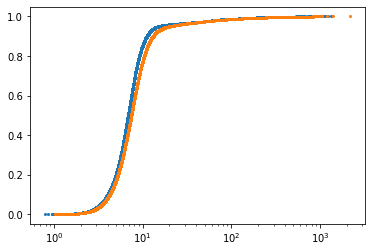

In [16]:
_, ax = plt.subplots(1, 1)
plot_cdf(ax, latency_of_config(sh_latency_df, "baseline.conf"), label="baseline", linewidth=0, marker='o')
plot_cdf(ax, latency_of_config(sh_latency_df, "ddr_ts.conf"), label="ddr_ts", linewidth=0, marker='o')

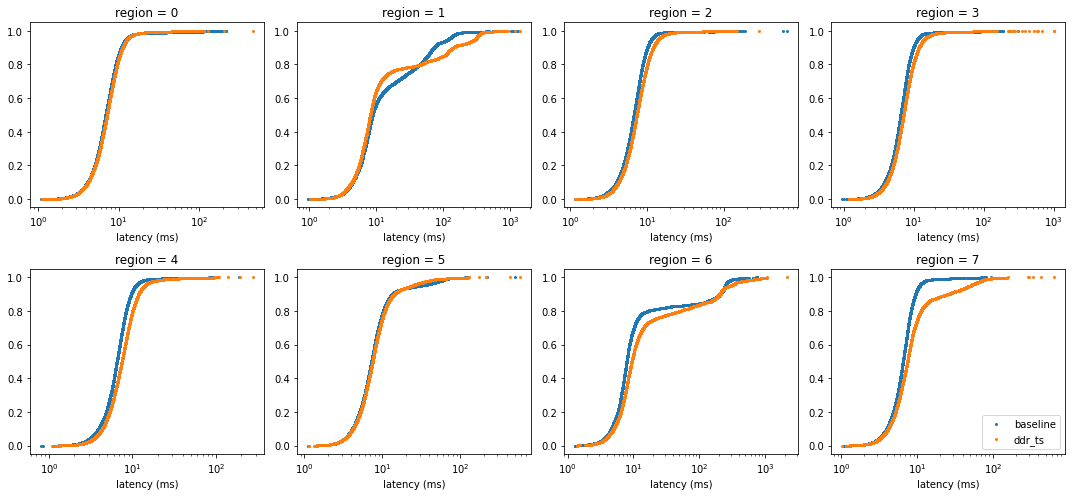

In [8]:
plot_latency_per_region(sh_latency_df)
plt.legend()
plt.tight_layout()

### Multi-Home

In [22]:
CLIENTS = 75
mh_latency_df = extract_latency(index_sdf, CLIENTS, 2)
mh_latency_df

,prefix,txn_id,coordinator,replicas,partitions,latency,version,config_name,duration,txns,clients,rate,sample,wl:name,wl:sh_only,wl:mix,wl:mh_zipf,wl:homes,wl:sp_partition,coordinator_region
0,file:///home/ctring/data/slog/main/tpcc/baseli...,15270404,4,"[0, 1]",[1],38.281984,1.0.916,baseline.conf,30,0,75,0,10,tpcc,0,45:43:4:4:4,1,2,-1,1
1,file:///home/ctring/data/slog/main/tpcc/baseli...,16152205,5,"[1, 2]",[0],89.220864,1.0.916,baseline.conf,30,0,75,0,10,tpcc,0,45:43:4:4:4,1,2,-1,1
2,file:///home/ctring/data/slog/main/tpcc/baseli...,16034603,3,"[1, 3]",[0],101.458176,1.0.916,baseline.conf,30,0,75,0,10,tpcc,0,45:43:4:4:4,1,2,-1,1
3,file:///home/ctring/data/slog/main/tpcc/baseli...,15656403,3,"[1, 6]",[2],257.474048,1.0.916,baseline.conf,30,0,75,0,10,tpcc,0,45:43:4:4:4,1,2,-1,1
4,file:///home/ctring/data/slog/main/tpcc/baseli...,14865404,4,"[0, 1]",[0],71.399680,1.0.916,baseline.conf,30,0,75,0,10,tpcc,0,45:43:4:4:4,1,2,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9527,file:///home/ctring/data/slog/main/tpcc/ddr_ts...,17994600,0,"[0, 5]",[1],171.495936,1.0.916,ddr_ts.conf,30,0,75,0,10,tpcc,0,45:43:4:4:4,1,2,-1,0
9528,file:///home/ctring/data/slog/main/tpcc/ddr_ts...,16170701,1,"[0, 2]",[0],88.087808,1.0.916,ddr_ts.conf,30,0,75,0,10,tpcc,0,45:43:4:4:4,1,2,-1,0
9529,file:///home/ctring/data/slog/main/tpcc/ddr_ts...,18296800,0,"[0, 2]",[0],92.032000,1.0.916,ddr_ts.conf,30,0,75,0,10,tpcc,0,45:43:4:4:4,1,2,-1,0
9530,file:///home/ctring/data/slog/main/tpcc/ddr_ts...,21662900,0,"[0, 1]",[0],31.809792,1.0.916,ddr_ts.conf,30,0,75,0,10,tpcc,0,45:43:4:4:4,1,2,-1,0


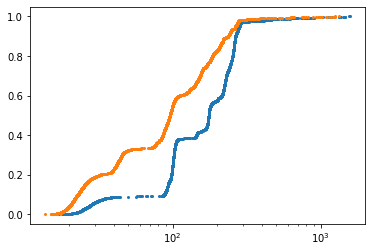

In [23]:
_, ax = plt.subplots(1, 1)
plot_cdf(ax, latency_of_config(mh_latency_df, "baseline.conf"), label="baseline", linewidth=0, marker='o')
plot_cdf(ax, latency_of_config(mh_latency_df, "ddr_ts.conf"), label="ddr_ts", linewidth=0, marker='o')

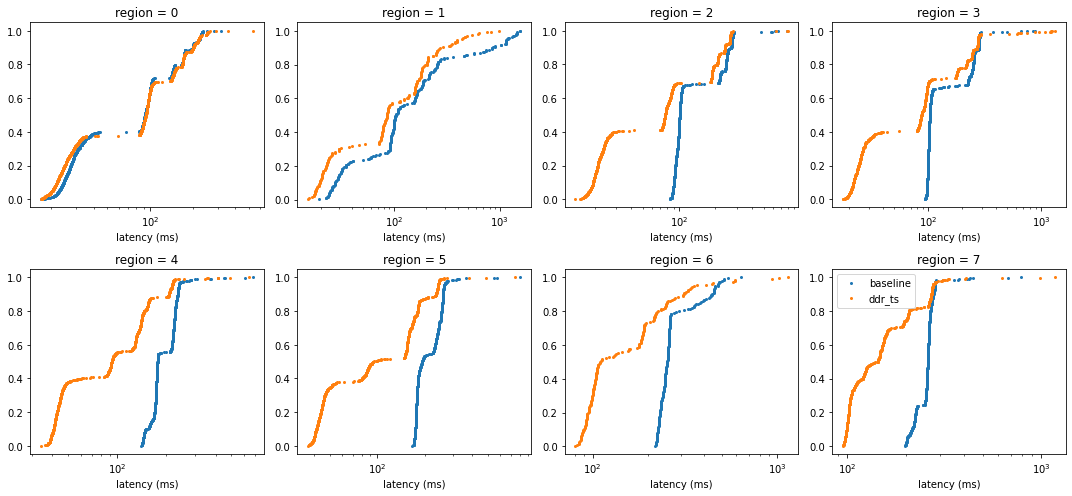

In [29]:
plot_latency_per_region(mh_latency_df)
plt.legend()
plt.tight_layout()

# Ad-hoc

In [ ]:
filtered = mh_latency_df[(mh_latency_df.coordinator_region == 7) & (mh_latency_df.latency > 1000)]
filtered["replicas_str"] = filtered.apply(lambda row : ','.join(map(str, row["replicas"])), axis=1)

In [ ]:
_, ax = plt.subplots(1, 1)
plot_cdf(ax, filtered[filtered.config_name == "baseline.conf"]["latency"])
plot_cdf(ax, filtered[filtered.config_name == "ddr_ts.conf"]["latency"])

In [ ]:
filtered[filtered.config_name == "ddr_ts.conf"].sort_values("latency")

In [ ]:
filtered[filtered.config_name == "baseline.conf"].sort_values("latency")